# Lab Four: Evaluation and Multi-Layer Perceptron

Arely Alcantara, Emily Fashenpour

## 1. Preparation and Overview

### 1.1 Business Case

The dataset that we selected is titled "Wine Quality" and it looks at a total of 6497 samples of both red and white wines - where there is a CSV file for red and white wines respectively. The dataset looks at 11 attributes of each wine sample such as the acidity, amount of alcohol, and density just to name a few. Each wine sample was also given a quality value that rates how good or bad that wine is on a numerical scale between 1 and 10. We take these quality values and define a range for either bad, ok, or great wines. Given a new wine company entering the market, we hope to be able to classify and find what its quality is relative to the other existing samples in our dataset. Third parties interested in this information might be new companies or people trying to enter the wine market and seeing how their creation relates to existing wines in the market and how its quality might be in relation to existing wineries. More and more people are now trying to start their own wineries as a side job - take Dylan Sprouse for instance, you may know him from his role in The Suite Life of Zack and Cody - he's an actor and yet he has his own winery in New York! (2)
We could essentially deploy this solution and charge a small fee to those companies/individuals wanting to find out what their wine quality is before they launch themselves into the market. In analyzing this dataset, we hope to help different wineries obtain a quality value for their wine creation and take into account the same attributes that our dataset uses.
Dataset URL: https://www.kaggle.com/danielpanizzo/wine-quality
Classification task: Classify a wine's quality as either bad, ok, or great quality.

### 1.2 Data Preparation

First, we're going to read in both of our CSV files and combine them to have one central source of information - we also added a color attribute, so that we know what each wine sample refers to in terms of red vs white wines. We're also going to remove column(s) that we feel aren't necessary for our analysis. We removed an index column that was included in both CSVs since we do not really care what a sample's position is in the dataset. Other than that, we feel like all of the other attributes are critical to determining the quality of a wine sample.

In [8]:
import pandas as pd
import numpy as np

#read red and white wine csv files respectively
redWines = pd.read_csv('wine-quality/wineQualityReds.csv')
whiteWines = pd.read_csv('wine-quality/wineQualityWhites.csv')
#add a color attribute, so we can differentiate between red and white wines
redWines['color']='Red'
whiteWines['color']='White'
#add both csv files so that there is only one dataframe
winesDf = pd.concat([redWines, whiteWines], ignore_index=True)

#drop unneeded columns
winesDf.drop(['Unnamed: 0'], axis=1, inplace=True)

#rename some columns - from periods to underscores to indicate spaces
winesDf = winesDf.rename(columns = {'fixed.acidity': 'fixed_acidity', 'volatile.acidity': 'volatile_acidity', 'citric.acid':'citric_acid', 'residual.sugar':'residual_sugar', 'free.sulfur.dioxide':'free_sulfur_dioxide', 'total.sulfur.dioxide': 'total_sulfur_dioxide'})

#shuffle rows and reset indices
winesDf = winesDf.sample(frac=1).reset_index(drop=True)
winesDf.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.5,0.38,0.33,9.2,0.043,19.0,116.0,0.99444,3.08,0.42,11.4,6,White
1,6.6,0.36,0.29,1.6,0.021,24.0,85.0,0.98965,3.41,0.61,12.4,9,White
2,8.5,0.21,0.41,4.3,0.036,24.0,99.0,0.99470,3.18,0.53,9.7,6,White
3,5.8,0.23,0.20,2.0,0.043,39.0,154.0,0.99226,3.21,0.39,10.2,6,White
4,6.9,0.24,0.40,15.4,0.052,81.0,198.0,0.99860,3.20,0.69,9.4,5,White


In [9]:
#show current column info with data type
print(winesDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
color                   6497 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
None


As you can see, most of the attributes are floats since most of the measures such as acidity, sugar, sulphates - are all numerical values that are needed to predict the quality of a wine sample - so, we have decided not to alter these values so that we can use all attributes and use those to classify a quality value. Later on we're going to change the quality ranges to 3 classes of bad, ok, and good. Where values of 1 to 4 are classified as 'bad' wines, 5 to 7 are 'ok' wines, and 8 to 10 are 'good' wines.

In [10]:
#change color to be an int
winesDf['color']=winesDf['color'].map({'Red': 1, 'White': 2})

winesDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
color                   6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [11]:
winesDf.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,1.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,1.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,2.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,2.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,2.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,2.000000


We have 6497 entries and every field is filled - therefore we have no missing data.

In [12]:
#create a dataframe to get a nice description table
data_des = pd.DataFrame()
data_des['Features'] = winesDf.columns
data_des['Description'] = ['does not evaporate readily',
                          ' the amount of acetic acid in wine',
                          'citric acid can add freshness and flavor to wines',
                          'sugar remaining after fermentation stops',
                          'the amount of salt in the wine',
                          'prevents microbial growth and the oxidation',
                          'SO2 becomes evident in the nose and taste of wine',
                          'water depending on the percent alcohol and sugar content',
                          'describes how acidic or basic a wine is',
                          'sulfur dioxide gas (S02) levels',
                          ' the percent alcohol content of the wine',
                          'value given by experts on wine quality',
                          'refers to color of wine']
data_des['Scale'] = ['ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'ratio', 'nominal', 'nominal']
data_des['Discrete/Continuous'] = ['continuous', 'continuous', 'continuous', 'continuous', 'continuous', 'continuous', 'continuous', 'continuous', 'continuous', 'continuous', 'continuous', 'discrete', 'discrete']
data_des['Range'] = ['3.8 - 15.9', '0.08 - 1.58', '0 - 1.66', '0.66 - 65.8','0.01 - 0.61','1 - 289','6 - 440','0.99 - 1.04','2.72 - 4.01','0.22 -2','8 - 14.9','0: Bad, 1: OK, 2: Great','1: Red, 2: White']
data_des

,Features,Description,Scale,Discrete/Continuous,Range
0,fixed_acidity,does not evaporate readily,ratio,continuous,3.8 - 15.9
1,volatile_acidity,the amount of acetic acid in wine,ratio,continuous,0.08 - 1.58
2,citric_acid,citric acid can add freshness and flavor to wines,ratio,continuous,0 - 1.66
3,residual_sugar,sugar remaining after fermentation stops,ratio,continuous,0.66 - 65.8
4,chlorides,the amount of salt in the wine,ratio,continuous,0.01 - 0.61
5,free_sulfur_dioxide,prevents microbial growth and the oxidation,ratio,continuous,1 - 289
6,total_sulfur_dioxide,SO2 becomes evident in the nose and taste of wine,ratio,continuous,6 - 440
7,density,water depending on the percent alcohol and sug...,ratio,continuous,0.99 - 1.04
8,pH,describes how acidic or basic a wine is,ratio,continuous,2.72 - 4.01
9,sulphates,sulfur dioxide gas (S02) levels,ratio,continuous,0.22 -2


In [13]:
#assign quality to 3 different classes instead of having 1-10 values
winesDf['quality'] = winesDf['quality'].map({1: 0, 2: 0, 3: 0, 4:0 ,5: 1, 6: 1, 7:1, 8:2, 9:2, 10:2})
winesDf.groupby('quality').size()

quality
0     246
1    6053
2     198
dtype: int64

Here we can see that our classes are not divided evenly - there are more 'ok' wines than there are 'bad' or 'great' wines - so a wine sample would have to perform rather poorly or extraordinary to be an outlier.

In [14]:
y = winesDf['quality']
X = winesDf.drop(['quality'], axis=1) # remove quality from X dataframe

We originally had 2 CSV files - one for red wines and one for white wines, so we ended up merging both files and shuffling the rows to have a randomized dataset. We removed an index column since that wouldn't be necessary for our analysis. We did end up adding an extra attribute for color since we're looking at both red and white wines. We are trying to classify a quality value given 11 attributes that are fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total dioxide, density, pH, sulphates, and alcohol. These attributes tell us how likely a wine sample is to evaporate, how sweet or acid it is, how much sugar there is, the water density, pH, and how much alcohol there is in the wine. So we did not remove any of those attributes as we feel that those are required for our classification.

In [15]:
from sklearn import preprocessing
# normalize data in X dataframe
winesDfContinuous = winesDf
winesDfContinuous = winesDfContinuous.drop(['quality', 'color'], axis=1)

# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(winesDfContinuous)
names = winesDfContinuous.columns
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df['color'] = winesDf['color']
X = scaled_df

## 2. Evaluation

### 2.1 Metric(s) selected and explanation

We believe that F1 scores seem to be a good performance metric since it takes the average of the precision and recall scores, so both false positives and false negatives are taken into account. We want to ensure that people who use our tool are getting the true quality value for their wine. We also have an uneven class distribution so there might be a few discrepancies in our model in terms of how it is trained and we do not want to let that affect the quality value that we provide so we will normalize our data before dividing the dataset into its respective training and testing sets. 

In addition, we are calculating accuracy because this measure takes both true positives and true negatives into account in relation to the total results - in our case, we're trying to predict wine quality given 3 classes so we want to see how accurate our predictions are. So, we will use accuracy sort of as a sanity check and ensure that we are training/testing appropriately.

### 2.2 Dividing data into training and testing sets

We chose to use stratified shuffle split to divide our dataset because since we had 2 different files to read from - the white and red csv files and we randomized the rows - however we feel that we need to randomize that data even more to get an even better representation of both kinds of wines. That addresses the shuffle part, and we want to use stratified so that each fold has the same amount of each class (bad, ok, great wine) and we're able to use all 3 classes to identify a quality measure for a wine sample.

In [16]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

#select model
clf = LogisticRegression()
#select cross validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1)

#select evaluation criteria
my_scorer = make_scorer(f1_score, average='macro') 

# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])
plt.show()

<Figure size 640x480 with 1 Axes>

## 3. Modeling

### 3.1 Our Implementation of Multilayer Perceptron

### Phi Function - Parameters
* __(Default)__ 'sigmoid' - Sigmoid Phi Function
* 'linear' - Linear Phi Function

### Cost Function - Parameters
* __(Default)__ - 'quadratic' - Quadratic Cost Function
* 'entropy' - Cross Entropy Cost Function

### Number of Hidden Layers
* Able to support any number

In [17]:
#two layer perceptron base from class
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [18]:
#inherit from Two Layer Perceptron Base class
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        
        # for each instance's activations 
        for (a1,a2,a3,y) in zip(A1.T,A2.T,A3.T,Y_enc.T):
            dJ_dz2 = -2*(y - a3)*a3*(1-a3)
            dJ_dz1 = dJ_dz2 @ W2 @ np.diag(a2*(1-a2))
                         
            grad2 += dJ_dz2[:,np.newaxis]  @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

In [19]:
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1)

In [20]:
#vectorized two layer perceptron
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [21]:
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_l_bfgs_b
class TLPVectorizedBFGS(TwoLayerPerceptronVectorized):
    
    def __init__(self, gtol=1e-5, **kwds):        
        # need to add to the original initializer 
        self.gtol = gtol
        
        # but keep other keywords
        super().__init__(**kwds)
        
    @staticmethod
    def _pack(in1, in2):
        '''Pack and flatten input vectors '''
        return np.hstack((in1.flatten(),in2.flatten()))
    
    def _unpack(self, in_tot):
        '''Undo packing according to layer weight sizes'''
        out1 = in_tot[:self.W1.size].reshape(self.W1.shape)
        out2 = in_tot[self.W1.size:].reshape(self.W2.shape)
        return out1, out2
    
    def _calc_cost_gradient_packed(self,W,X_data,Y_enc):
        '''Unpack and get cost, gradient for bfgs'''
        W1, W2 = self._unpack(W) 
        # feedforward all instances
        A1, Z1, A2, Z2, A3 = self._feedforward(X_data,W1,W2)
        
        cost = np.sum((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        cost = cost + L2_term
        #perform back prop to get gradients
        grad1,grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3,Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                         W1=W1, W2=W2)
        return cost, self._pack(grad1,grad2)
    
    def _cost_packed(self,W,X_data,Y_enc):
        '''Unpack and calculate MSE for bfgs'''
        W1, W2 = self._unpack(W)
        _, _, _, _, A3 = self._feedforward(X_data,W1,W2)
        return np.sum((Y_enc-A3)**2)
    
    def fit(self,X,y,print_progress=0):
        '''Learn weights from training data'''
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # make initial matrices into single row vector
        W = self._pack(self.W1,self.W2)
        
        if print_progress>0:
            def callback(xd):
                callback.counter += 1
                if callback.counter%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d (max)' % (callback.counter,callback.epochs))
                    sys.stderr.flush()

            callback.counter = 0
            callback.epochs = self.epochs
            
        else:
            callback = None
            
        # compute gradient optimum with bfgs
        W_best,_,props = fmin_l_bfgs_b(
                        x0=W,
                        func=self._calc_cost_gradient_packed,
                        maxfun=self.epochs,
                        callback=callback,
                        pgtol=self.gtol,
                        args=(X_data, Y_enc))
        
        self.W1, self.W2 = self._unpack(W_best)
        if print_progress:
            print(props)

We have finished importing the code from class which covers a two layer perceptron. We will use this to see how the two layer perceptron performs with our dataset and then we will start building a multilayer perceptron using the aboe two layer perceptron.

In [22]:
%%time
nn_bfgs = TLPVectorizedBFGS(**params, gtol=1e-3)

import time

X=np.array(X)
y=np.array(y)

def calculate_metrics(method,X,y):
    f1_score_sum=0.0
    precision_sum=0.0
    accuracy_sum=0.0
    
    #go through each fold and calculate metrics based on the method passed in used to predict a class
    for train_index, test_index in cv.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        method.fit(X_train, y_train)
        
        yhat = method.predict(X_test)
        
        f1_score_sum+=f1_score(y_test, yhat, average='macro')
        accuracy_sum+=accuracy_score(y_test,yhat)
        precision_sum+=precision_score(y_test, yhat, average='macro')
    return f1_score_sum/cv.get_n_splits(X), accuracy_sum/cv.get_n_splits(X), precision_sum/cv.get_n_splits(X)

print(calculate_metrics(nn_bfgs,X,y))

(0.4274475300004202, 0.9232307692307693, 0.5254010987528016)
CPU times: user 46.8 s, sys: 601 ms, total: 47.4 s
Wall time: 8.25 s


ANALYSIS GOES HERE FOR f1_score/accuracy precision, if we get a better f1_score

### Multilayer Perceptron

In [156]:
class MultiLayerPerceptronBase(object):
    def __init__(self, n_layers=2, n_hidden=30, C=0.0, epochs=500, 
                 eta=0.001, phi='sigmoid', cost='quadratic',random_state=None):
        np.random.seed(random_state)
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.phi = phi
        self.cost = cost
        
    @staticmethod
    def _encode_labels(y): #one hot encode labels
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self): #initialize weights with small random numbers
        W = []
        i = 0
        
        #initializing W1
        num_elems = (self.n_features_ + 1) * self.n_hidden
        W_temp = np.random.uniform(-1.0, 1.0, size=num_elems)
        W_temp = W_temp.reshape(self.n_hidden, self.n_features_ + 1)
        W.append(W_temp)
        
        while i < (self.n_layers - 2):
            num_elems = (self.n_hidden) * (W[i].shape[0] + 1)
            W_temp = np.random.uniform(-1.0, 1.0, size=num_elems)
            W_temp = W_temp.reshape(self.n_hidden, (W[i].shape[0] + 1))
            W.append(W_temp)
            i += 1

        #initializing last weight
        num_elems = (self.n_output_) * (W[i].shape[0] + 1)
        W_temp = np.random.uniform(-1.0, 1.0, size=num_elems)
        W_temp = W_temp.reshape(self.n_output_, (W[i].shape[0] + 1))
        W.append(W_temp)
        
        return W
    
    def _activation(self, z):
        if self.phi == 'linear':
            return self._linear(z)
        if self.phi == 'sigmoid':
            return self._sigmoid(z)
    
    @staticmethod
    def _sigmoid(z): #use scipy expit function to avoid overflow
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _linear(z):
        return z
    
    @staticmethod
    def _add_bias_unit(X, how='column'): #add bias unit of 1s as either a column or row to array at index 0
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W): #compute L2 regularization cost
        # only compute for non-bias terms
        W_mean_sum = 0
        for w in W:
            W_mean_sum += np.mean(w[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(W_mean_sum)
    
    def _cost(self, A_last, Y_enc, W): # get objective function value
        if self.cost == 'quadratic':
            cost = np.mean((Y_enc-A_last)**2)
            L2_term = self._L2_reg(self.l2_C, W)
        if self.cost == 'entropy':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_last)+(1-Y_enc)*np.log(1-A_last))))
            L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term

In [222]:
class MultiLayerPerceptron(MultiLayerPerceptronBase):
    def _feedforward(self, X, W): #compute feedforward steps
        A = []
        Z = []
        
        A_temp = self._add_bias_unit(X.T, how='row')
        A.append(A_temp)
        
        for i in range(self.n_layers - 1):
            Z_temp = W[i] @ A[i]
            Z.append(Z_temp)
            A_temp = self._activation(Z[i])
            A_temp = self._add_bias_unit(A_temp, how='row')
            A.append(A_temp)
            
        Z_temp = W[self.n_layers - 1] @ A[self.n_layers - 1]
        Z.append(Z_temp)
        A_temp = self._activation(Z[self.n_layers - 1])
        A.append(A_temp)
    
        return A, Z
    
    
    def _get_gradient(self, A, Z, Y_enc, W): #compute gradient step using backpropagation
        grad = []
        V = []
        
        #calculating last sensitivity
        V_temp = -2*(Y_enc-A[self.n_layers])*A[self.n_layers]*(1-A[self.n_layers])
        V.append(V_temp)
        
        grad_temp = V[0] @ (A[self.n_layers - 1]).T
        grad.append(grad_temp)
        grad[0] += W[self.n_layers - 1] * self.l2_C
        
        for i in range(self.n_layers - 1):
            V_temp = A[self.n_layers - i-1][1:,:] * (1-A[self.n_layers - i-1])[1:,:] * (((W[self.n_layers - i-1]).T)[1:,:] @ V[i])
            V.append(V_temp)
            
            grad_temp = V[i+1] @ (A[self.n_layers - i-2]).T
            grad_temp += (W[self.n_layers - i-2]) * self.l2_C
            grad.append(grad_temp)
            
        #need to reverse the orded of the sensitivities (V) and gradients (grad)
        #because they were appended in reverse order (V2, V1...)
        V = V[::-1]
        grad = grad[::-1]

        return grad
    
    def predict(self, X): #predict class labels
        A, Z = self._feedforward(X, self.W)
        y_pred = np.argmax(A[self.n_layers], axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False): #learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        #initialize weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.grad = []
        self.grad_W_ = []
        for i in range(self.n_layers):
            self.grad_W_.append(np.zeros(self.epochs))
            
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A, Z = self._feedforward(X_data, self.W)
            
            cost = self._cost(A[self.n_layers],Y_enc,self.W)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            self.grad = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc, W=self.W) 
            
            for g in range(self.n_layers):
                self.W[g] -= self.eta * self.grad[g]
                self.grad_W_[g][i] = np.mean(self.grad[g]) / np.std(self.grad[g])
                
                
        return self

In [223]:
%%time
params = dict(n_layers=4,
              n_hidden=80, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = MultiLayerPerceptron(**params)
X=np.array(X)
y=np.array(y)

def calculate_metrics(method,X,y):
    f1_score_sum=0.0
    precision_sum=0.0
    accuracy_sum=0.0
    
    #go through each fold and calculate metrics based on the method passed in used to predict a class
    for train_index, test_index in cv.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        method.fit(X_train, y_train)
        
        yhat = method.predict(X_test)
        
        f1_score_sum+=f1_score(y_test, yhat, average='macro')
        accuracy_sum+=accuracy_score(y_test,yhat)
        precision_sum+=precision_score(y_test, yhat, average='macro')
    return f1_score_sum/cv.get_n_splits(X), accuracy_sum/cv.get_n_splits(X), precision_sum/cv.get_n_splits(X)

print(calculate_metrics(nn,X,y))

(0.3239134503882427, 0.9313846153846155, 0.32166487007754396)
CPU times: user 3min 44s, sys: 4.88 s, total: 3min 48s
Wall time: 38.4 s


### 3.2 Tuning hyper parameters

Now that our implementation is done, we will play around with different combinations of parameters to see what happens on our multilayer perceptron.

In [179]:
activation = ['sigmoid', 'linear']
cost = ['quadratic', 'entropy']
hidden_layers = [2, 3, 5]
hidden_neurons = [50, 90]
epoch = [500, 800]

X=np.array(X)
y=np.array(y)
        
#using sigmoid activation function and quadratic cost function
print('Activation: Sigmoid & Cost: Quadratic')
for layer in hidden_layers:
    for epo in epoch:
        for neur in hidden_neurons:
            params = dict(n_layers=layer, n_hidden=neur, C=0.1, epochs=epo, 
                      eta=0.001, phi='sigmoid', cost='quadratic', random_state=1)
            nn = MultiLayerPerceptron(**params)
            print('Layers: ', layer,' &  Epochs: ', epo,' &  Neurons: ', neur, ' -> ',calculate_metrics(nn,X,y))
    print(' ')

Activation: Sigmoid & Cost: Quadratic
Layers:  2  &  Epochs:  500  &  Neurons:  50  ->  (0.32150490035080703, 0.9314615384615385, 0.3105110637373917)
Layers:  2  &  Epochs:  500  &  Neurons:  90  ->  (0.32151865126775514, 0.9315384615384616, 0.31051282051282053)
Layers:  2  &  Epochs:  800  &  Neurons:  50  ->  (0.32150490035080703, 0.9314615384615385, 0.3105110637373917)
Layers:  2  &  Epochs:  800  &  Neurons:  90  ->  (0.3228647941091071, 0.9316153846153847, 0.3438700578354158)
 
Layers:  3  &  Epochs:  500  &  Neurons:  50  ->  (0.32274803562356047, 0.9313846153846155, 0.3188648306426084)
Layers:  3  &  Epochs:  500  &  Neurons:  90  ->  (0.32151865126775514, 0.9315384615384616, 0.31051282051282053)
Layers:  3  &  Epochs:  800  &  Neurons:  50  ->  (0.32645189962203724, 0.9312307692307693, 0.3617057030837349)
Layers:  3  &  Epochs:  800  &  Neurons:  90  ->  (0.32151865126775514, 0.9315384615384616, 0.31051282051282053)
 
Layers:  5  &  Epochs:  500  &  Neurons:  50  ->  (0.3215186

In [228]:
#using sigmoid activation function and cross entropy (negative log loss) cost function
print('Activation: Sigmoid & Cost: Cross Entropy')
for layer in hidden_layers:
    for epo in epoch:
        for neur in hidden_neurons:
            params = dict(n_layers=layer, n_hidden=neur, C=0.1, epochs=epo, 
                      eta=0.001, phi='sigmoid', cost='entropy', random_state=1)
            nn = MultiLayerPerceptron(**params)
            print('Layers: ', layer,' &  Epochs: ', epo,' &  Neurons: ', neur, ' -> ',calculate_metrics(nn,X,y))
    print(' ')

Activation: Sigmoid & Cost: Cross Entropy
Layers:  2  &  Epochs:  500  &  Neurons:  50  ->  (0.32150490035080703, 0.9314615384615385, 0.3105110637373917)
Layers:  2  &  Epochs:  500  &  Neurons:  90  ->  (0.32151865126775514, 0.9315384615384616, 0.31051282051282053)
Layers:  2  &  Epochs:  800  &  Neurons:  50  ->  (0.32150490035080703, 0.9314615384615385, 0.3105110637373917)
Layers:  2  &  Epochs:  800  &  Neurons:  90  ->  (0.3228647941091071, 0.9316153846153847, 0.3438700578354158)
 
Layers:  3  &  Epochs:  500  &  Neurons:  50  ->  (0.32274803562356047, 0.9313846153846155, 0.3188648306426084)
Layers:  3  &  Epochs:  500  &  Neurons:  90  ->  (0.32151865126775514, 0.9315384615384616, 0.31051282051282053)
Layers:  3  &  Epochs:  800  &  Neurons:  50  ->  (0.32645189962203724, 0.9312307692307693, 0.3617057030837349)
Layers:  3  &  Epochs:  800  &  Neurons:  90  ->  (0.32151865126775514, 0.9315384615384616, 0.31051282051282053)
 
Layers:  5  &  Epochs:  500  &  Neurons:  50  ->  (0.321

In [229]:
#using linear activation function and quadratic cost function
print('Activation: Linear & Cost: Quadratic')
for layer in hidden_layers:
    for epo in epoch:
        for neur in hidden_neurons:
            params = dict(n_layers=layer, n_hidden=neur, C=0.1, epochs=epo, 
                      eta=0.001, phi='linear', cost='quadratic', random_state=1)
            nn = MultiLayerPerceptron(**params)
            print('Layers: ', layer,' &  Epochs: ', epo,' &  Neurons: ', neur, ' -> ',calculate_metrics(nn,X,y))
    print(' ')

Activation: Linear & Cost: Quadratic
Layers:  2  &  Epochs:  500  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  2  &  Epochs:  500  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  2  &  Epochs:  800  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  2  &  Epochs:  800  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
 
Layers:  3  &  Epochs:  500  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  3  &  Epochs:  500  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  3  &  Epochs:  800  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  3  &  Epochs:  800  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
 
Layers:  5  &  Epochs:  500  & 

In [230]:
#using linear activation function and cross entropy (negative log loss) cost function
print('Activation: Linear & Cost: Cross Entropy')
for layer in hidden_layers:
    for epo in epoch:
        for neur in hidden_neurons:
            params = dict(n_layers=layer, n_hidden=neur, C=0.1, epochs=epo, 
                      eta=0.001, phi='linear', cost='entropy', random_state=1)
            nn = MultiLayerPerceptron(**params)
            print('Layers: ', layer,' &  Epochs: ', epo,' &  Neurons: ', neur, ' -> ',calculate_metrics(nn,X,y))
    print(' ')

Activation: Linear & Cost: Cross Entropy
Layers:  2  &  Epochs:  500  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  2  &  Epochs:  500  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  2  &  Epochs:  800  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  2  &  Epochs:  800  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
 
Layers:  3  &  Epochs:  500  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  3  &  Epochs:  500  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  3  &  Epochs:  800  &  Neurons:  50  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
Layers:  3  &  Epochs:  800  &  Neurons:  90  ->  (0.024215468248085004, 0.03769230769230769, 0.012564102564102564)
 
Layers:  5  &  Epochs:  500

### 3.3 Visualizing magnitude of gradients in  each layer

(0.32645189962203724, 0.9312307692307693, 0.3617057030837349)
3


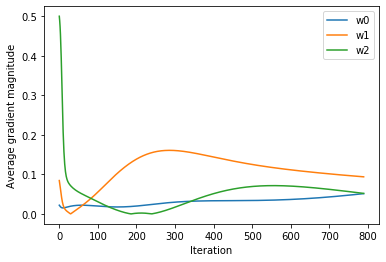

In [231]:
import matplotlib.pyplot as plt
%matplotlib inline

params = dict(n_layers=3, n_hidden=50, C=0.1, epochs=800, 
                      eta=0.001, phi='sigmoid', cost='quadratic', random_state=1)
nn = MultiLayerPerceptron(**params)
print(calculate_metrics(nn,X,y))

ax = plt.subplot(1,1,1)
for i in range(len(nn.grad)):
    plt.plot(abs(nn.grad_W_[i][10:]), label=('w'+str(i)))
    
print(len(nn.grad))

plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

## 4. Exceptional Work

We completed the biometrics research study session with Elena Sharp in the Johnson Square building.

## References

1. Wine Quality Dataset. Kaggle. https://www.kaggle.com/danielpanizzo/wine-quality
2. Dylan Sprouse Is The CEO Of All-Wise Meadery & It's The Career He's Always Wanted. Amanda Fama. August 13, 2018. https://www.elitedaily.com/p/dylan-sprouse-is-the-ceo-of-all-wise-meadery-its-the-career-hes-always-wanted-9979370